In [ ]:
# autoreload module
# https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
# set tf to cpu only
tf.config.set_visible_devices([], 'GPU')

import jax
jax.config.update('jax_platform_name', 'cpu')

# Import Network
import torch
from bc.bc_dataset import BCDataset, BCDatasetTester
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# Test Sampleing

In [ ]:
dataset = BCDatasetTester(
    data_path='/Data/Dataset/Waymo/V1_2_tf/training_extracted',
)
dataloader = DataLoader(dataset, batch_size=128, 
                        shuffle=False, num_workers=16,
                        pin_memory=False,
                        # collate_fn=dataset.collate_fn)
                        collate_fn=lambda x: x)

In [43]:
bin_historgram = np.zeros((6*8,), dtype=np.int32)
histogram = {}

for i, batch in enumerate(dataloader):
    for b, d, _ in batch:
        d = tuple(d)
        if d not in histogram:
            histogram[d] = 0
        histogram[d] += 1
        
        bin_historgram[b] += 1
    if i > 10_000:
        break

KeyboardInterrupt: 

[[0.    0.    0.004 0.003 0.    0.    0.    0.001]
 [0.037 0.037 0.002 0.    0.004 0.018 0.037 0.037]
 [0.021 0.006 0.037 0.037 0.037 0.037 0.037 0.037]
 [0.037 0.037 0.037 0.037 0.037 0.037 0.037 0.037]
 [0.037 0.037 0.037 0.037 0.005 0.015 0.037 0.037]
 [0.019 0.008 0.    0.    0.002 0.001 0.    0.   ]]


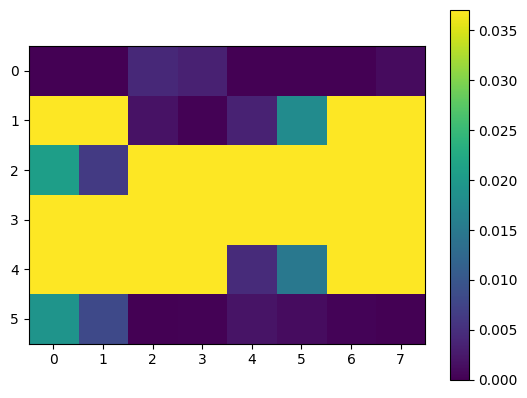

In [42]:
sample_p = np.clip(dataset.histogram, 0, 1e4)
# sample_p = np.log(dataset.histogram+1)
# sample_p = dataset.histogram
sample_p = sample_p / np.sum(sample_p)

plt.imshow(sample_p.reshape(6, 8))
plt.colorbar()
print(np.round(sample_p.reshape(6, 8), 3))

In [46]:
print(i)
val_list = list(histogram.values())
print(sorted(val_list)[-10:])

3216
[22, 22, 22, 22, 25, 26, 28, 32, 35, 42]


In [ ]:
def test():
    bin_idx = np.random.choice(len(dataset.sample_p), p=dataset.sample_p)
    cache_id = np.random.randint(dataset.histogram[bin_idx])
    cache = dataset.idx_cache[bin_idx][cache_id]
    dataset.retrive_one(cache)

%timeit test()

# Get mean and variance


In [ ]:
def calc(n, running_sum, running_sum_square):
    mean  = running_sum / n
    var = running_sum_square / n - mean**2
    std = var**0.5
    
    print('mean: ', mean)
    print('var: ', var)
    print('std: ', std)

In [ ]:
running_sum = 0
running_sum_square = 0
n = 0

for i, (_, _, gt) in tqdm(enumerate(dataloader), total=10000):
    # print(batch)
    # break
    running_sum += gt.sum(axis=0)
    running_sum_square += (gt**2).sum(axis=0)
    n += gt.shape[0]
    
    if i >= 100:
        break
calc(n, running_sum, running_sum_square)

In [ ]:
calc(n, running_sum, running_sum_square)

In [ ]:
def estimate_mean_and_variance(hist, x_edges, y_edges):
    
    x_mean = np.sum(hist * x_edges[:, np.newaxis]) / np.sum(hist)
    y_mean = np.sum(hist * y_edges[np.newaxis, :]) / np.sum(hist)
    
    x_var = np.sum(hist * (x_edges[:, np.newaxis] - x_mean)**2) / np.sum(hist)
    y_var = np.sum(hist * (y_edges[np.newaxis, :] - y_mean)**2) / np.sum(hist)
    
    return x_mean, y_mean, np.sqrt(x_var), np.sqrt(y_var)

hist = np.zeros([len(dataset.accel_grid), len(dataset.steer_grid)])
for key, val in dataset.cache['idx_cache'].items():
    i = key[0]
    j = key[1]
    hist[i,j] = np.log(len(val)+1)

x_mean, y_mean, x_var, y_var = estimate_mean_and_variance(hist, dataset.accel_grid, dataset.steer_grid)
print('x_mean:', x_mean)
print('y_mean:', y_mean)
print('x_var:', x_var)
print('y_var:', y_var)


In [ ]:
# Create a figure and axis for plotting
fig, ax = plt.subplots()

# Plot the initial histogram
im = ax.imshow(np.log(hist.T+1), origin='lower',
            extent=[dataset.accel_grid[0], dataset.accel_grid[-1], dataset.steer_grid[0], dataset.steer_grid[-1]],
            aspect='auto')

plt.colorbar(im, ax=ax, label='Log Counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Histogram')

plt.show()


In [ ]:
np.linspace(-0.4,0.4,5)